# Predicting Maternal Health Risk

Group 45 Members: Mehr Bains, Anais Smart, Madilynn Smith

In [2]:
# Install these libraries before continuing!
library(tidyverse)
library(tidymodels)
install.packages("kknn")
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [3]:
# Set the seed for reproducibility (do not change)
set.seed(105)

## Introduction

Maternal mortality is a global health issue that disparately affects women in low to middle-income countries. Reduction of maternal deaths, many of which are preventable, is a key target for the [UN Sustainable Development Goals for 2030](https://www.who.int/data/gho/data/themes/topics/sdg-target-3-1-maternal-mortality). This investigation aims to answer whether we can **predict the risk level (low, medium, high) for a pregnant woman based on risk factors including age, blood glucose level, heart rate, and body temperature, using KNN classification.** The dataset is pulled from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/863/maternal+health+risk) and collected by remote healthcare facilities in Bangladesh using IoT (wearable sensor technology). The dataset contains 1013 observations of risk level for pregnant women described with 6 features:

1. Age (in years)
2. Systolic blood pressure (in mmHg)
3. Diastolic blood pressure (in mmHg)
4. Blood sugar/glucose (in mmol/L) 
5. Body temperature (in Fahrenheit) 
6. Heart rate (in beats per minute)

## Exploratory Data Analysis

The dataset is read in using a URL and wrangled to convert the RiskLevel variable into a factor type. Another column is added for a variable called MAP, which will be one of the chosen predictor variables explained below. 

In [4]:
# Reading in data from a URL
url <- "https://raw.githubusercontent.com/mehrbains/Maternal-Health-Risk-Data/main/Maternal%20Health%20Risk%20Data%20Set%203.csv"
risk_data <- read_csv(url) |>
             mutate(RiskLevel = as_factor(RiskLevel)) |>
             mutate(MAP = ((SystolicBP + (2 * DiastolicBP))/3))
risk_data

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,MAP
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
25,130,80,15.00,98,86,high risk,96.66667
35,140,90,13.00,98,70,high risk,106.66667
29,90,70,8.00,100,80,high risk,76.66667
30,140,85,7.00,98,70,high risk,103.33333
35,120,60,6.10,98,76,low risk,80.00000
23,140,80,7.01,98,70,high risk,100.00000
23,130,70,7.01,98,78,mid risk,90.00000
35,85,60,11.00,102,86,high risk,68.33333
32,120,90,6.90,98,70,mid risk,100.00000


The dataset meets the [3 criteria for tidy data](https://datasciencebook.ca/wrangling.html#tidy-data): each row is a single observation, each column is a single variable, and each value is a single cell. However, the data is not standardized (centred and scaled) yet. 

Next, the dataset is split as 75% training data and 25% testing data to ensure exploratory data analysis and model building will only be carried out on training data. Summary statistics are also generated to understand the data better and identify any rows with missing values.

In [5]:
# Splitting the dataset into training data and testing data, and checking the 75/25 split
risk_split <- initial_split(risk_data, prop = 0.75, strata = RiskLevel)
risk_train <- training(risk_split)
risk_test <- testing(risk_split)

glimpse(risk_train)
glimpse(risk_test)

Rows: 760
Columns: 8
$ Age         <dbl> 25, 35, 29, 30, 23, 35, 42, 40, 25, 23, 34, 50, 25, 42, 32…
$ SystolicBP  <dbl> 130, 140, 90, 140, 140, 85, 130, 140, 140, 140, 85, 140, 1…
$ DiastolicBP <dbl> 80, 90, 70, 85, 80, 60, 80, 100, 100, 90, 60, 90, 100, 100…
$ BS          <dbl> 15.00, 13.00, 8.00, 7.00, 7.01, 11.00, 18.00, 18.00, 6.80,…
$ BodyTemp    <dbl> 98, 98, 100, 98, 98, 102, 98, 98, 98, 98, 102, 98, 98, 98,…
$ HeartRate   <dbl> 86, 70, 80, 70, 70, 86, 70, 90, 80, 70, 86, 90, 80, 90, 78…
$ RiskLevel   <fct> high risk, high risk, high risk, high risk, high risk, hig…
$ MAP         <dbl> 96.66667, 106.66667, 76.66667, 103.33333, 100.00000, 68.33…
Rows: 254
Columns: 8
$ Age         <dbl> 48, 50, 25, 30, 50, 21, 21, 49, 20, 22, 21, 45, 35, 25, 23…
$ SystolicBP  <dbl> 120, 140, 140, 120, 140, 90, 120, 120, 100, 120, 75, 120, …
$ DiastolicBP <dbl> 80, 90, 100, 80, 80, 65, 80, 90, 90, 90, 50, 95, 70, 70, 9…
$ BS          <dbl> 11.00, 15.00, 7.01, 6.90, 6.70, 7.50, 7.50, 7.20, 7.10, 7.

In [6]:
# Finding the number of rows with missing values ("NA") in training dataset
missing_values <- sum(is.na(risk_train))
missing_values

[1] 0

In [7]:
# Summary statistics: number of observations in each class and % of total observations
num_obs <- nrow(risk_train)
summary_obs <- risk_train |>
           group_by(RiskLevel) |>
           summarize(Count = n(),
                     Percentage = n() / num_obs * 100)
summary_obs

# Summary statistics: average of each chosen predictor variable 
summary_pred <- risk_train |>
                select(BS, MAP) |>
                map(mean)
summary_pred

RiskLevel,Count,Percentage
<fct>,<int>,<dbl>
high risk,204,26.84211
low risk,304,40.00000
mid risk,252,33.15789


$BS
[1] 8.723434

$MAP
[1] 88.55351

The 3 different classes are approximately balanced. 

Next, histograms are used to visualize the distribution of each chosen predictor variable. 

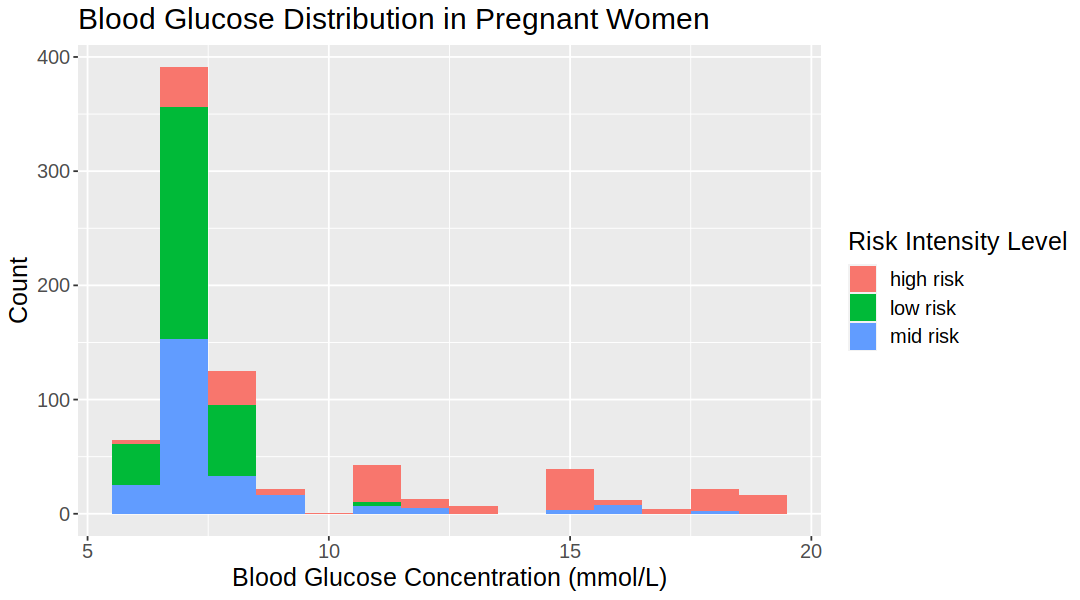

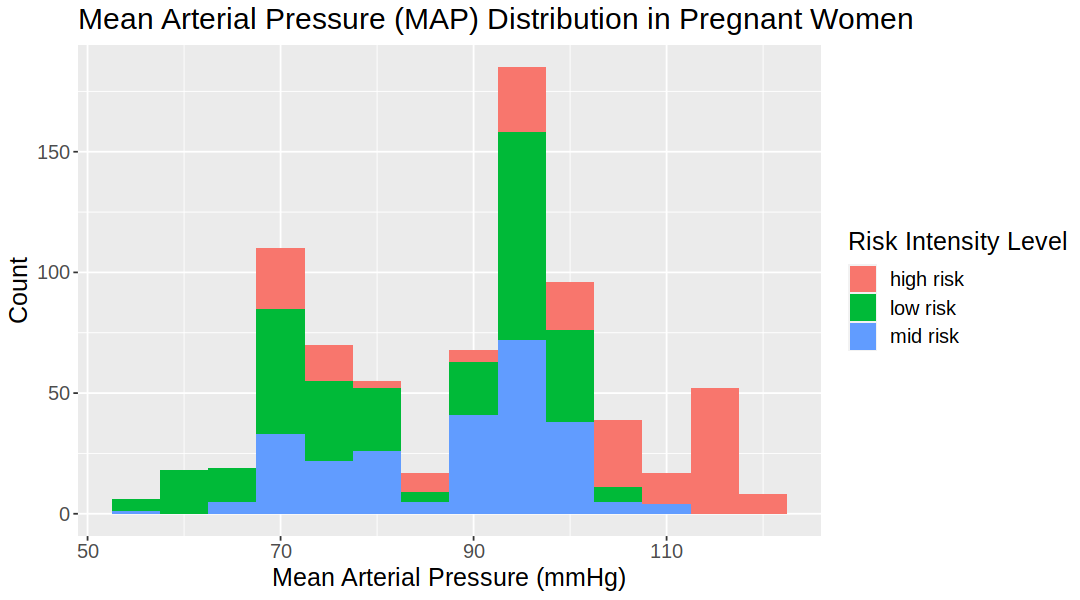

In [8]:
# Comparing distributions of predictor variables

options(repr.plot.width = 9, repr.plot.height = 5)

glucose_viz <- risk_train |>
               ggplot(aes(x = BS, fill = RiskLevel)) +
               geom_histogram(binwidth = 1) + 
               ggtitle("Blood Glucose Distribution in Pregnant Women") +
               labs(x = "Blood Glucose Concentration (mmol/L)",
                    y = "Count",
                    fill = "Risk Intensity Level") +
               theme(text = element_text(size = 15))
glucose_viz

map_viz <- risk_train |>
           ggplot(aes(x = MAP, fill = RiskLevel)) +
           geom_histogram(binwidth = 5) + 
           ggtitle("Mean Arterial Pressure (MAP) Distribution in Pregnant Women") +
           labs(x = "Mean Arterial Pressure (mmHg)",
                y = "Count",
                fill = "Risk Intensity Level") +
           theme(text = element_text(size = 15))
map_viz

At higher blood glucose concentrations, there are fewer data points however the risk tends to be high or medium, rather than low. Higher MAP values, especially at 110 mmHg and higher, correspond with higher risk intensity.

## Methods

Data analysis will be done using the KNN classification algorithm. The training data will be standardized prior to continuing. The number of neighbors to use will be determined by splitting training data for cross-validation, to improve estimated prediction accuracy. A new model specification using the best parameter value for K will be used to retrain the classifier. Then, accuracy will be tested using the testing dataset.  

**MAP** and **blood glucose** are chosen as the predictor variables. 

MAP has been considered to be a [better indicator](https://www.nursingcenter.com/ncblog/december-2011/calculating-the-map#:~:text=MAP%2C%20or%20mean%20arterial%20pressure,systolic%20blood%20pressure%20(SBP).) of the overall exposure of an individual to higher blood pressures than systolic or diastolic blood pressure alone. Hypertension (high blood pressure) is the [2nd](https://www.health.harvard.edu/blog/can-monitoring-blood-pressure-at-home-cut-maternal-mortality-2019120318455) leading cause of maternal mortality, therefore MAP was chosen as an important predictor. High MAP values [(> 99.0 mmHg)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10046034/#:~:text=An%20optimal%20MAP%20value%20is,MAP%20values%20are%20%E2%89%A5132.34.) are considered hypertensive. MAP is calculated in a new column by applying a [formula](https://www.nursingcenter.com/ncblog/december-2011/calculating-the-map#:~:text=MAP%2C%20or%20mean%20arterial%20pressure,systolic%20blood%20pressure%20(SBP).).

Blood glucose is selected because [maternal dysglycemia](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8020552/), a range of conditions related to glucose imbalances, is a major risk factor for maternal health. For example, gestational diabetes increases the risk for birth complications by 8-fold if untreated. 

The results will be visualized using a colored prediction map as the background for a scatter plot of blood glucose versus MAP. 

In [9]:
#10-fold cross-validation of training data

risk_vfold <- vfold_cv(risk_train, v = 5, strata = RiskLevel)

In [10]:
#Recipe

risk_recipe <- recipe(RiskLevel ~ MAP + BS, data = risk_train) |>
               step_scale(all_predictors()) |>
               step_center(all_predictors())
risk_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [11]:
#K nearest neighbor model specification (tuning)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
#K values to test

k_vals <- tibble(neighbors = seq(from = 1, to = 30))

In [13]:
#Workflow to combine recipe and tuning model spec, fit model to each K value, aggregate mean and standard error, filter for accuracy

## Do I need to set a new seed here? also in any other code boxes?

risk_results <- workflow() |>
      add_recipe(risk_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = risk_vfold, grid = k_vals) |>
      collect_metrics() |>
      filter(.metric == "accuracy")
risk_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6221751,5,0.020706368,Preprocessor1_Model01
2,accuracy,multiclass,0.6144100,5,0.012085217,Preprocessor1_Model02
3,accuracy,multiclass,0.6144455,5,0.012370668,Preprocessor1_Model03
4,accuracy,multiclass,0.5934176,5,0.009539416,Preprocessor1_Model04
5,accuracy,multiclass,0.6380351,5,0.020340091,Preprocessor1_Model05
6,accuracy,multiclass,0.6328246,5,0.022754211,Preprocessor1_Model06
7,accuracy,multiclass,0.6368060,5,0.017328567,Preprocessor1_Model07
8,accuracy,multiclass,0.6314465,5,0.018874608,Preprocessor1_Model08
9,accuracy,multiclass,0.6367798,5,0.019237723,Preprocessor1_Model09


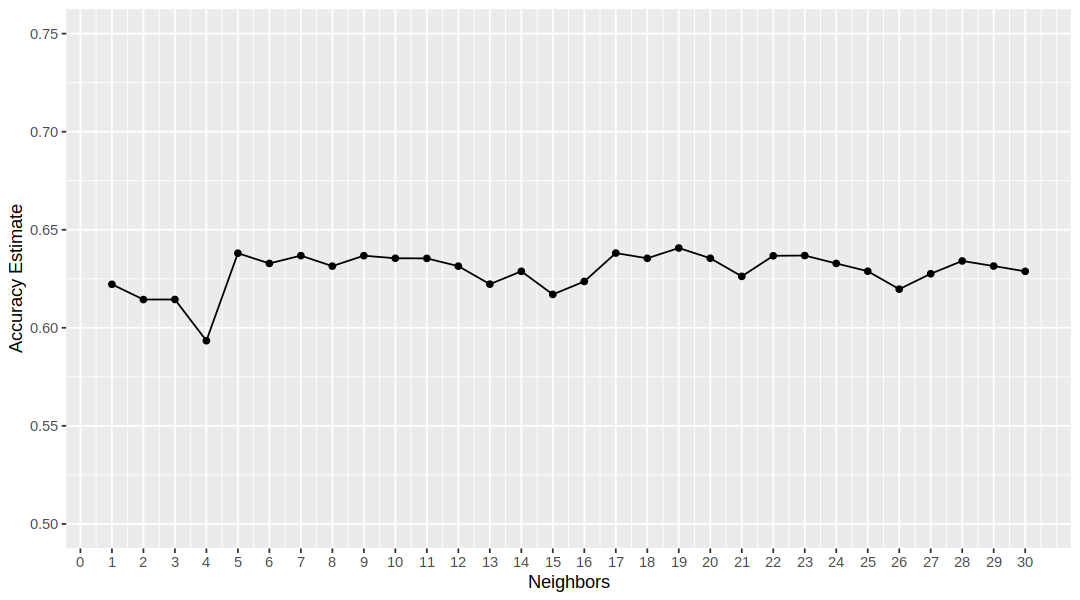

In [14]:
#Line plot of accuracies vs. neighbors 

accuracy_versus_k <- ggplot(risk_results, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 30, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.5, 0.75)) # adjusting the y-axis
accuracy_versus_k

(rationalize K value chosen)

In [15]:
#Create model specification with optimal K value

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
      set_engine("kknn") |>
      set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


In [16]:
#Workflow to fit recipe and model to training data

risk_fit <- workflow() |>
      add_recipe(risk_recipe) |>
      add_model(knn_spec) |>
      fit(data = risk_train)
risk_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2973684
Best kernel: rectangular
Best k: 5

In [17]:
#Predict on testing data using final model, accuracy and confusion matrix report

risk_predictions <- predict(risk_fit, risk_test) |>
                    bind_cols(risk_test)
risk_predictions

risk_metrics <- risk_predictions |>
                metrics(truth = RiskLevel, estimate = .pred_class)
risk_metrics
## What is kap?

risk_conf_mat <- risk_predictions |>
                 conf_mat(truth = RiskLevel, estimate = .pred_class)
risk_conf_mat

.pred_class,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,MAP
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
high risk,48,120,80,11.00,98,88,mid risk,93.33333
high risk,50,140,90,15.00,98,90,high risk,106.66667
high risk,25,140,100,7.01,98,80,high risk,113.33333
low risk,30,120,80,6.90,101,76,mid risk,93.33333
mid risk,50,140,80,6.70,98,70,mid risk,100.00000
low risk,21,90,65,7.50,98,76,low risk,73.33333
low risk,21,120,80,7.50,98,76,low risk,93.33333
high risk,49,120,90,7.20,98,77,low risk,100.00000
low risk,20,100,90,7.10,98,88,low risk,93.33333


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6732283
kap,multiclass,0.4972816


           Truth
Prediction  high risk low risk mid risk
  high risk        57        5       11
  low risk          7       84       43
  mid risk          4       13       30

[Recall](https://www.evidentlyai.com/classification-metrics/multi-class-metrics) calculations: 
 
correct low risk predictions / all low risk instances = 87 / (5 + 87 + 10) = 87 / 102 = 0.85

correct mid risk predictions / all mid risk instances = 34 / (7 + 43 + 34) = 34 / 84 = 0.40

correct high risk predictions / all high risk instances = 53 / (53 + 6 + 9) = 53 / 68 = 0.78


[Precision](https://www.evidentlyai.com/classification-metrics/multi-class-metrics) calculations:

correct low risk predictions / all low risk predictions = 87 / (6 + 87 + 43) = 0.64

correct mid risk predictions / all mid risk predictions = 34 / (9 + 10 + 34) = 0.64

correct high risk predictions / all high risk predictions = 53 / (53 + 5 + 7) = 0.82

For K = 5: higher recall for high risk, lower recall for low risk, same recall for mid risk

For K = 5: same precision for high risk, lower precision for low risk, higher precision for mid risk

For K = 5: lower accuracy and kap

## Expected Outcomes & Significance

We expect the classifier predicts higher risk levels for higher blood glucose and higher MAP, and to prioritize higher recall than higher precision. This helps ensure pregnant women at high risk are able to receive appropriate medical attention.  

The impact of these findings would be more accurate identification of women at high risk and increasing the likelihood of these women to receive medical care to lower maternal mortality rates. It is an alternative method to risk classification compared to the more subjective method used by clinicians where their knowledge and experience is relied on. If such a model were implemented in a real clinical setting and able to successfully improve risk identification to lower mortality rates, it could become a significant tool, especially in remote areas with less access to healthcare, and increase trust and reliability of data science algorithms to assist in improving healthcare outcomes.  

Future questions could involve exploring other possibly significant variables to improve the classifier or using a different classification method entirely, such as a decision tree. 

## Visualization

Using the scaled testing set of data, the points are plotted onto the now trained K-nearest neighbor model. Each point is plotted and categorized into a color-coded category for the specific class it is predicted to be in. This visualization shows the accuracy of our model and assesses the performance on unseen data points.  

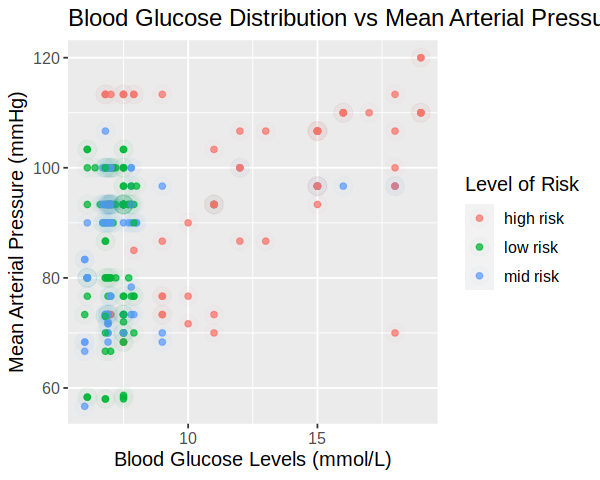

In [21]:
#Plot the visualization
options(repr.plot.width = 5, repr.plot.height=4)
wkflw_plot <-
  ggplot() +
  geom_point(data = risk_test, 
             mapping = aes(x = BS, 
                           y = MAP, 
                           color = RiskLevel), 
             alpha = 0.75) +
  geom_point(data = risk_predictions, 
             mapping = aes(x = BS, 
                           y = MAP, 
                           color = RiskLevel), 
             alpha = 0.02, 
             size = 5) +
  labs(title = "Blood Glucose Distribution vs Mean Arterial Pressure in Pregnant Women",
    color = "Level of Risk", 
       x = "Blood Glucose Levels (mmol/L)", 
       y = "Mean Arterial Pressure (mmHg)") +
  theme(text = element_text(size = 12))

wkflw_plot

## References

Farid, H. (2019, December 3). Can monitoring blood pressure at home cut maternal mortality? - Harvard Health. Harvard Health; Harvard Health. https://www.health.harvard.edu/blog/can-monitoring-blood-pressure-at-home-cut-maternal-mortality-2019120318455

How to Calculate Mean Arterial Pressure (MAP). (2018). Nursingcenter.com. https://www.nursingcenter.com/ncblog/december-2011/calculating-the-map#:~:text=MAP%2C%20or%20mean%20arterial%20pressure,systolic%20blood%20pressure%20(SBP).

Kandil, H., Soliman, A., Norah Saleh Alghamdi, J. Richard Jennings, & Ayman El-Baz. (2023). Using Mean Arterial Pressure in Hypertension Diagnosis versus Using Either Systolic or Diastolic Blood Pressure Measurements. Biomedicines, 11(3), 849–849. https://doi.org/10.3390/biomedicines11030849

SDG Target 3.1 Maternal mortality. (2022). Who.int. https://www.who.int/data/gho/data/themes/topics/sdg-target-3-1-maternal-mortality

Silva, C. M., Arnegard, M. E., & Maric‐Bilkan, C. (2021). Dysglycemia in Pregnancy and Maternal/Fetal Outcomes. Journal of Womens Health, 30(2), 187–193. https://doi.org/10.1089/jwh.2020.8853
‌
Timbers, T. (2023, August 31). Chapter 3 Cleaning and wrangling data | Data Science. Datasciencebook.ca. https://datasciencebook.ca/wrangling.html#tidy-data

UCI Machine Learning Repository. (2023). Uci.edu. https://archive.ics.uci.edu/dataset/863/maternal+health+risk

Accuracy, Precision, and Recall in Multi-Class Classification. (2023). Evidentlyai.com. www.evidentlyai.com/classification-metrics/multi-class-metrics